In [2]:
import pandas as pd
from collections import Counter
import numpy as np

df = pd.read_csv("fake_data.csv", encoding_errors="ignore", on_bad_lines='skip', sep=",",)
df = pd.read_csv("BPI2016_Clicks_Logged_In.csv", encoding_errors="ignore", on_bad_lines='skip', sep=";",
                usecols=['CustomerID', 'AgeCategory', 'Gender', 'Office_U', 'Office_W',
       'SessionID', 'IPID', 'TIMESTAMP', 'VHOST', 'URL_FILE', 'PAGE_NAME',
       'REF_URL_category', 'page_load_error', 'page_action_detail', 'tip',
       'service_detail', 'xps_info'])
df.rename(columns={'URL_FILE':'Activity'}, inplace=True)

C:\Users\krdeg\AppData\Local\Temp\ipykernel_9768\1922496564.py:6: DtypeWarning: Columns (11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("BPI2016_Clicks_Logged_In.csv", encoding_errors="ignore", on_bad_lines='skip', sep=";",


In [3]:
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], infer_datetime_format=True)
df = df.sort_values(["SessionID", "TIMESTAMP"])

In [4]:
#Create consecutive column with the consecutive activity and count how many time each pair occurs
df["Consecutive_1"] = df.groupby("SessionID")["Activity"].shift(periods=-1)

#Count all the pairs and safe in new DataFrame
df_for_pivot_1 = pd.DataFrame(Counter(list(zip(df['Activity'], df['Consecutive_1'],))), index=["value"]).T.reset_index()

df_for_pivot_1.fillna("end_session", inplace=True)
df_for_pivot_1

,level_0,level_1,value
0,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,/werk_nl/werknemer/mijn_werkmap/doorgeven/mijn...,123143
1,/werk_nl/werknemer/mijn_werkmap/doorgeven/mijn...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_d...,2442
2,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_d...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,21692
3,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,241943
4,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,end_session,53821
...,...,...,...
15942,/xpsimage/wdo215419,/xpsimage/wdo215419,3
15943,/xpsimage/wdo213133,/xpsimage/wdo215419,1
15944,/xpsimage/wdo215419,/xpsimage/wdo211812,1
15945,/portal/page/portal/werk_nl/werknemer/sollicit...,/werk_nl/werknemer/solliciteren/solliciteren-w...,1


In [5]:
def make_pivot(df, index_names, column_names):
    """
    Functions that takes in a DataFrame and returns a pivot table with all the chances
    
    Create pivot table where chances are calculated that each row is succeded by activity that is represented in the column
    """
    df_chances = df.pivot_table(index=index_names, columns=column_names, values='value')
    
    #Calculate what the probabilities are by summing the row and dividing all the values in the row by total sum of the row
    df_chances["total_row_count"] = df_chances.sum(axis=1)
    df_chances = df_chances.div(df_chances["total_row_count"], axis=0)
    
    df_chances.fillna(0, inplace=True)
    df_chances.drop("total_row_count", axis=1, inplace=True)

    return df_chances

In [6]:
df_chances_1 = make_pivot(df_for_pivot_1, "level_0", "level_1")

#Calculate the probability of each activity that it is the first activity performed in the session
df_chances_1["start_session_chance"] = df.groupby("SessionID").nth(0)["Activity"].value_counts() / df.groupby("SessionID").nth(0)["Activity"].value_counts().sum()
df_chances_1.fillna(0, inplace=True)

In [7]:
df_chances_total = df_chances_1 

#Split the start probabilities from the normal DataFrame
start_chances = df_chances_total["start_session_chance"][df_chances_total["start_session_chance"] > 0]

#Create df with all chances except the starting chance.
df_chances_rest = df_chances_total.iloc[:, :-1]

In [8]:
df_chances_rest

level_1,/,//,//portal/page/portal/werk_nl/werknemer/solliciteren/solliciteren-werk-zoeken/sollicitatiebrief,//werk_nl/werknemer/contact,//werk_nl/werknemer/contact/email_uw_vraag,//werk_nl/werknemer/contact/vestiging-zoeken,//werk_nl/werknemer/home,//werk_nl/werknemer/over-werk-nl/handleiding,//werk_nl/werknemer/over-werk-nl/handleiding/cv-plaatsen,//werk_nl/werknemer/over-werk-nl/handleiding/sollicitatie-wijziging,...,/xpsitem/wdo_013389,/xpsitem/wdo_013407,/xpsitem/wdo_013827,/xpsitem/wdo_014041,/zoeken_portlet/ajax/addVacatureToGereageerd,/zoeken_portlet/ajax/zoekAantalIndicatief,/zoeken_portlet/ajax/zoekBeroep,/zoeken_portlet_wg/ajax/selectContactpersoon,/zoeken_portlet_wg/ajax/selectVacature,end_session
level_0,,,,,,,,,,,,,,,,,,,,,
/,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.073834
//,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.035714
//portal/page/portal/werk_nl/werknemer/solliciteren/solliciteren-werk-zoeken/sollicitatiebrief,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
//werk_nl/werknemer/contact,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
//werk_nl/werknemer/contact/email_uw_vraag,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/zoeken_portlet/ajax/addVacatureToGereageerd,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017588,0.002513,0.005025,0.0,0.0,0.055276
/zoeken_portlet/ajax/zoekAantalIndicatief,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000107,0.537184,0.051269,0.0,0.0,0.007539
/zoeken_portlet/ajax/zoekBeroep,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.441592,0.489910,0.0,0.0,0.003979


Try to find paths of length 3.
A - B - C
Sort on chance. 
So chance a to b * b to c 

In [9]:
def find_paths(_df:pd.DataFrame,len:int = 3):
  df = _df.copy()
  col = df.columns.values
  row  = df.index.values
  s  = row.size
  res = []
  while s > 0:
    current_row = df.iloc[row.size - s]
    i = 0
    while i < current_row.size:
      current_col = df.columns[i]
      chance = current_row.iloc[i]
      if chance > 0:
        a = current_row.name
        b = current_col
        
        if (df.index == b).any() :
          _r = df.loc[b]
          index = 0
          for r in _r:
            if r > 0:
              res.append([a,b,col.item(index),r*chance])  
            index += 1        
            
      i += 1
    s -= 1

  return res


paths = find_paths(df_chances_rest)

In [10]:
df_paths = pd.DataFrame(paths,columns=['a','b','c','Chance'])

In [11]:
df_paths.sort_values(by= ["Chance"],ascending=False,inplace=True,ignore_index=True)
df_paths

,a,b,c,Chance
0,/xpsimage/wdo_011743,/xpsimage/wdo_011744,end_session,1.000000e+00
1,/werk_nl/werkgever/mijn_werk_nl/mijn_bedrijfsp...,/werk_nl/werkgever/mijn_werk_nl/mijn_zoekopdra...,/werk_nl/werkgever/cvs_zoeken,1.000000e+00
2,/werk_nl/werknemer/solliciteren/europa/land/sl...,/werk_nl/werknemer/solliciteren/europa/land/ho...,/werk_nl/werknemer/solliciteren/europa/land/polen,1.000000e+00
3,/portal/page/portal/werk_nl/werkgever/meerwete...,/portal/page/portal/werk_nl/werkgever/meerwete...,end_session,1.000000e+00
4,/werk_nl/werknemer/solliciteren/europa/land/ts...,/werk_nl/werknemer/solliciteren/europa/land/sl...,/werk_nl/werknemer/solliciteren/europa/land/ho...,1.000000e+00
...,...,...,...,...
1362215,/portal/page/portal/home/diensten/aanvragen-ww,/werk_nl/werknemer/mijn_werkmap/werk-zoeken/va...,//werk_nl/werknemer/solliciteren/ontwikkel-uze...,4.785496e-11
1362216,/portal/page/portal/home/diensten/aanvragen-ww,/werk_nl/werknemer/mijn_werkmap/werk-zoeken/va...,/xpsitem/wdo_010560,4.785496e-11
1362217,/portal/page/portal/home/diensten/aanvragen-ww,/werk_nl/werknemer/mijn_werkmap/werk-zoeken/va...,/xpsitem/wdo_008957,4.785496e-11
1362218,/portal/page/portal/home/diensten/aanvragen-ww,/werk_nl/werknemer/mijn_werkmap/werk-zoeken/va...,/xpsitem/ptl1716476,4.785496e-11


In [90]:
df_test = df_paths.copy()
df_test.head(100000)

,a,b,c,Chance
0,/xpsimage/wdo_011743,/xpsimage/wdo_011744,end_session,1.000000
1,/werk_nl/werkgever/mijn_werk_nl/mijn_bedrijfsp...,/werk_nl/werkgever/mijn_werk_nl/mijn_zoekopdra...,/werk_nl/werkgever/cvs_zoeken,1.000000
2,/werk_nl/werknemer/solliciteren/europa/land/sl...,/werk_nl/werknemer/solliciteren/europa/land/ho...,/werk_nl/werknemer/solliciteren/europa/land/polen,1.000000
3,/portal/page/portal/werk_nl/werkgever/meerwete...,/portal/page/portal/werk_nl/werkgever/meerwete...,end_session,1.000000
4,/werk_nl/werknemer/solliciteren/europa/land/ts...,/werk_nl/werknemer/solliciteren/europa/land/sl...,/werk_nl/werknemer/solliciteren/europa/land/ho...,1.000000
...,...,...,...,...
99995,/xpsimage/wdo212395,/werk_nl/werknemer/mijn_werkmap/inschrijving/m...,/werk_nl/werknemer/eintake/inschrijven,0.000381
99996,/xpsimage/wdo211812,/xpsimage/wdo211682,/xpsimage/wdo211812,0.000381
99997,/xpsimage/wdo211812,/xpsimage/wdo211682,/xpsimage/wdo211818,0.000381
99998,/xpsimage/wdo211682,/xpsimage/wdo211812,/xpsimage/wdo211682,0.000381


<AxesSubplot:>

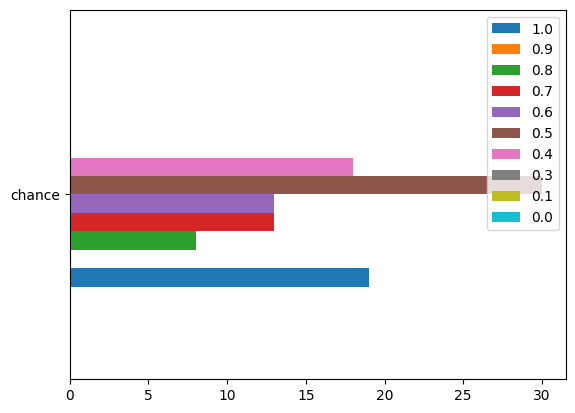

In [86]:
import matplotlib.pyplot as plt
import math


def round_decimals_down(number:float, decimals:int=1):
    """
    Returns a value rounded down to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor


data = df_test.head(101)["Chance"]
ranges = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.1,0.0]
# count = [0,0,0,0,0,0,0,0,0,0]

new_df = pd.DataFrame(columns=ranges,index=["chance"])
new_df.loc['chance'] = pd.Series({1:0,0.9:0,0.8:0,0.7:0,0.6:0,0.5:0,0.4:0,0.3:0,0.1:0,0.0:0})

for d in data:
  if not new_df[round_decimals_down(d)][0] :
    new_df[round_decimals_down(d)][0] = 1
  else:
    new_df[round_decimals_down(d)][0] += 1
    
new_df.plot.barh()
